<h1>Customer Churn</h1>

Hier wird es darum gehen, ob Kunden bei bestimmten Bedingungen eher dazu neigen, die Bank zu verlassen.

Es werden einige Visualisierungen gezeigt und die Daten werden bereinigt. Später soll das Model mit Flask verfügbar gemacht werden.

Dataset:

> Bank Customer Churn Dataset: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset [Letzter Zugriff: 03.07.2024]

In [221]:
# Imports.
import pandas  as pd
import numpy   as np
import seaborn as sn

import matplotlib.pyplot as plt

from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import pickle

<h2>Explore</h2>

In [2]:
# Lade CSV.
churn_df = pd.read_csv('./data/archive.zip', compression='zip')
churn_df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# 12 Features und 10.000 Einträge.
churn_df.shape

(10000, 12)

In [4]:
churn_df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

Die meisten Features sind schon numerisch. <br>
Das Feature "customer_id" liefert uns keinen Mehrwert, also wird es gedropt. 

In [5]:
churn_df.drop(['customer_id'], axis='columns', inplace=True)
churn_df.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [6]:
# Nutze unique(), um Werte von bestimmten Spalten anzuzeigen. 
# - np.setdiff1d: löscht Einträge die wir nicht brauchen.
for col in np.setdiff1d(churn_df.columns, ['age', 'balance', 'balance', 'estimated_salary', 'credit_score']):
    print(f'{col}:')
    print(churn_df[col].unique())

active_member:
[1 0]
churn:
[1 0]
country:
['France' 'Spain' 'Germany']
credit_card:
[1 0]
gender:
['Female' 'Male']
products_number:
[1 3 2 4]
tenure:
[ 2  1  8  7  4  6  3 10  5  9  0]


In [7]:
churn_df.isnull().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Als Nächstes müssen die nicht-numerischen Features codiert werden. 

In [8]:
target   = ['France', 'Spain', 'Germany'] 
ersetzen = [0, 1, 2]

for target, replace in zip(target, ersetzen):
    churn_df.replace(target, replace, inplace=True)

churn_df['country'].values

C:\Users\Alexander\AppData\Local\Temp\ipykernel_11860\1410523213.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn_df.replace(target, replace, inplace=True)


array([0, 1, 0, ..., 0, 2, 0], dtype=int64)

In [9]:
# On-Hot Encode Gender
churn_df['gender'] = pd.get_dummies(churn_df['gender'], drop_first=True, dtype='int')
# Female: 0, Male: 1
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [10]:
churn_df.dtypes

credit_score          int64
country               int64
gender                int32
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

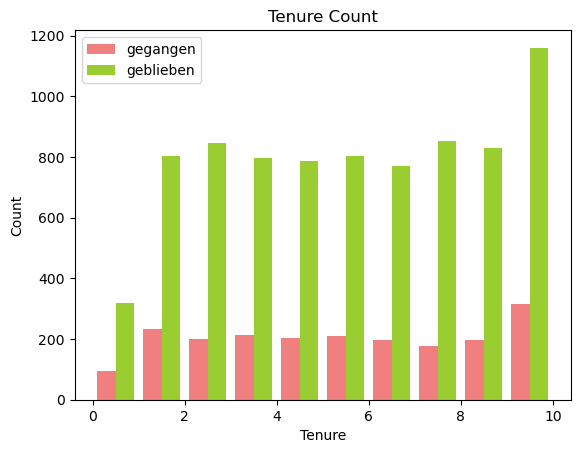

In [11]:
# tenure: Wie lange ist diese Person ein Kunde gewesen?
# - In Jahren, siehe Dataset Beschreibung.

plt.title("Tenure Count")
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.hist([ churn_df[churn_df['churn']==1].tenure, churn_df[churn_df['churn']==0].tenure ], \
        color=['lightcoral', 'yellowgreen'],  label=['gegangen', 'geblieben'])
plt.legend()

Man sieht, dass die Churn-Quote bei den Menschen die gehen, relativ gleich bleibt.

In [12]:
# Sind die Klassen ausgeglichen? 
churn_df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

C:\Users\Alexander\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

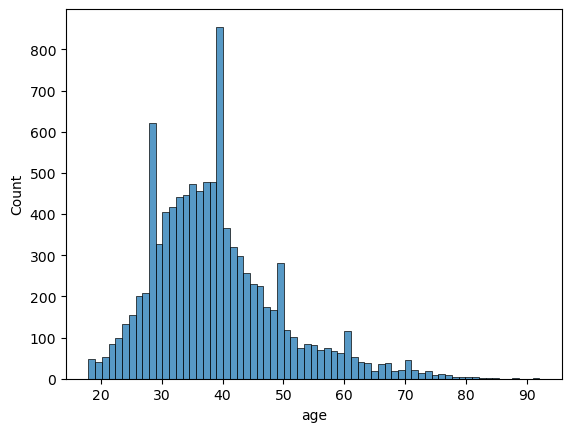

In [13]:
# Wie ist das Alter aufgeteilt? 
sn.histplot(churn_df['age'])

Customer Churn Datasets sind meist unbalanciert. Später werden wir es mit einer Methode balancieren.

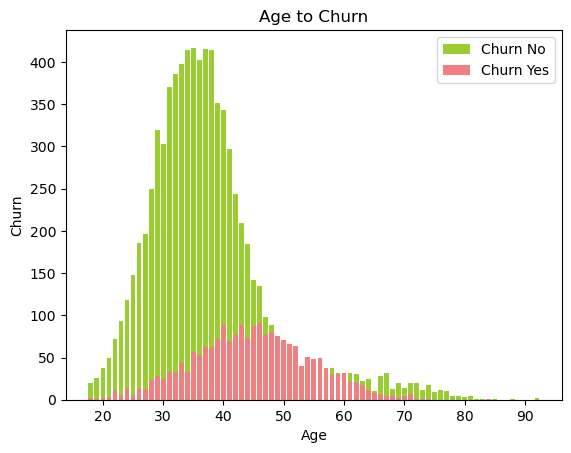

In [15]:
# Age zu Churn.

# Wie viele sind im Alter gegangen?
plt.title("Age to Churn")
plt.xlabel("Age")
plt.ylabel('Churn')

churn_yes = churn_df[['age', 'churn']].loc[churn_df['churn']==1].groupby('age')['churn'].value_counts().unstack(fill_value=0)
churn_no = churn_df[['age', 'churn']].loc[churn_df['churn']==0].groupby('age')['churn'].value_counts().unstack(fill_value=0)
plt.bar(churn_no.index,  churn_no[0],   label='Churn No',  color="yellowgreen")
plt.bar(churn_yes.index, churn_yes[1],  label='Churn Yes', color="lightcoral")
plt.legend()

Auf diesem Plot sieht man, dass das Alter der Personen hauptsächlich in dem Bereich 25 bis 60 liegt. Die jüngeren Leute bleiben eher und ab dem Alter von 35 steigt die Anzahl der Leute die Gehen. Ab da könnte man diesen Leuten Angebote unterbreiten, um diese zum Bleiben anzuregen.

Man sieht auch einige Wucherungen nach rechts, wo es wenig Daten gibt. Weit rechts stehende Werte sind Outlier.

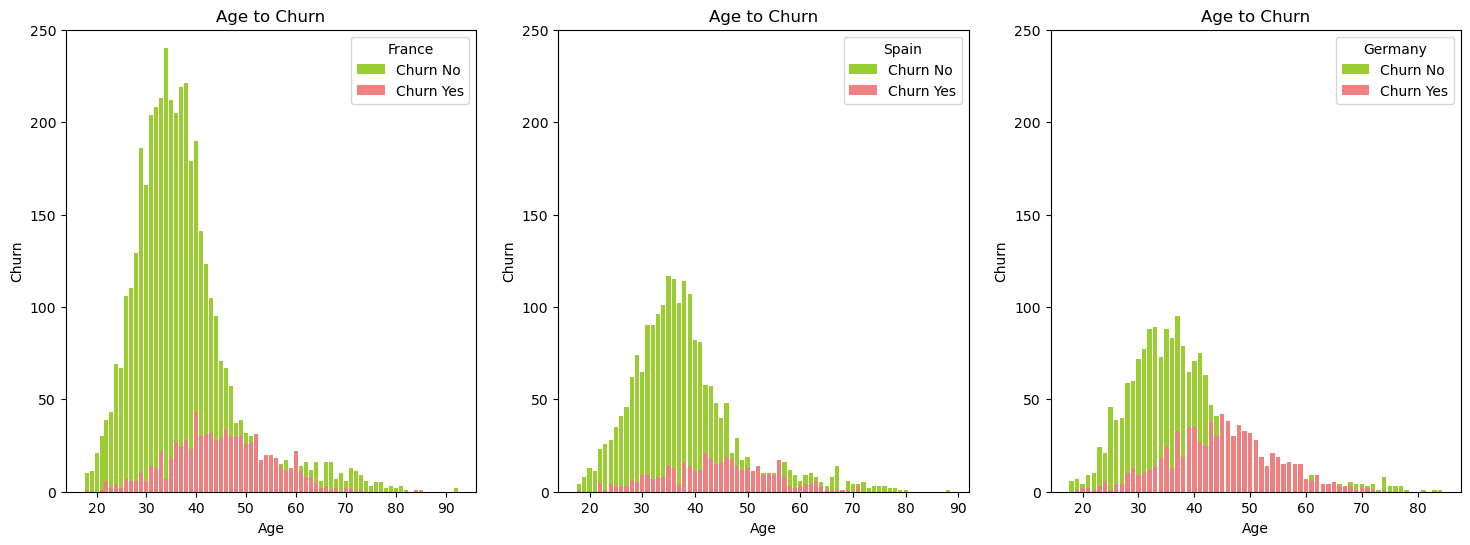

In [16]:
## Plot: Age to Churn gruppiert nach Ländern. 
country = ['France', 'Spain', 'Germany'] 

fig, axs = plt.subplots(1,3, figsize=(18, 6))
axs = axs.ravel()

for i in range(3):
    churn_no  = churn_df[['age', 'churn', 'country']].loc[(churn_df['churn']==0) & (churn_df['country']==i) ].groupby('age')['churn'].value_counts().unstack(fill_value=0)
    churn_yes = churn_df[['age', 'churn', 'country']].loc[(churn_df['churn']==1) & (churn_df['country']==i) ].groupby('age')['churn'].value_counts().unstack(fill_value=0)
    axs[i].set_title("Age to Churn")
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Churn')
    axs[i].set_ylim(0, 250)
    axs[i].bar(churn_no.index,  churn_no[0],    label='Churn No',  color="yellowgreen")
    axs[i].bar(churn_yes.index,  churn_yes[1],  label='Churn Yes', color="lightcoral")
    axs[i].legend(title=country[i])

Durch das Spezifizieren der Länder kann untersucht werden, welche Gegebenheiten dazu führen, dass Leute bleiben oder gehen. Das ist wichtig, da in jedem Land andere Regeln gelten und Menschen sich anders verhalten mögen, doch gibt es Ähnlichkeiten.

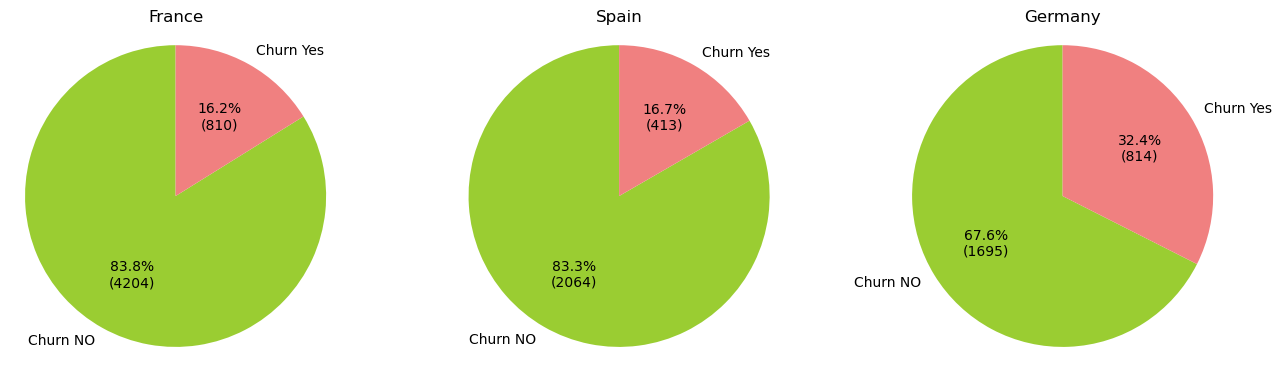

In [16]:
## Plot: Übersicht als Piechart. 
fig, axs = plt.subplots(1,3, figsize=(14, 5))
fig.tight_layout(pad=5.0)
axs = axs.ravel()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

for i in range(3):
    churn_no  = churn_df[['churn', 'country']].loc[(churn_df['churn']==0) & (churn_df['country']==i) ].groupby('country').value_counts().unstack(fill_value=0)
    churn_yes = churn_df[['churn', 'country']].loc[(churn_df['churn']==1) & (churn_df['country']==i) ].groupby('country').value_counts().unstack(fill_value=0)
    axs[i].set_title(country[i])
    axs[i].pie([np.sum( churn_no[0].values ), np.sum( churn_yes[1].values )],\
               startangle=90, colors=["yellowgreen", 'lightcoral'], labels=['Churn NO', 'Churn Yes'], autopct=lambda pct: func(pct, np.sum( churn_no[0].values ) + np.sum( churn_yes[1].values )))
    axs[i].axis('equal')

([<matplotlib.patches.Wedge at 0x1bd7dffc400>,
 [Text(-0.6568642010431011, -0.8823431426537006, 'Churn NO'),
  Text(0.6568642010431012, 0.8823431426537006, 'Churn Yes')],
 [Text(-0.3582895642053278, -0.4812780778111093, '79.6%\n(7963)'),
  Text(0.35828956420532787, 0.4812780778111093, '20.4%\n(2037)')])

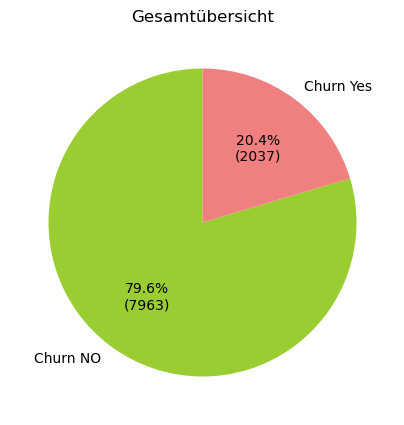

In [17]:
## Plot: Gesamtüberblick.
plt.figure(figsize=(14, 5))
  
churn_no  = churn_df['churn'].value_counts()[0]
churn_yes = churn_df['churn'].value_counts()[1]
plt.title("Gesamtübersicht")
plt.pie([churn_no, churn_yes],\
               startangle=90, colors=["yellowgreen",'lightcoral'], labels=['Churn NO', 'Churn Yes'], autopct=lambda pct: func(pct, churn_no + churn_yes))
    

Wir können uns weitere Einzelheiten anschauen.<br>
Welche dieser Features ist mehr ausschlaggebend? 

In [17]:
# Nochmal das Dataframe als Überblick.
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [18]:
# Zusammenfassung des Dataframes.
churn_df.describe()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.749500,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,2.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [24]:
# Nach Geschlecht.
# - Female: 0, Male: 1
gender_df = churn_df[['gender', 'churn']].groupby('gender').value_counts().unstack(fill_value=0)
gender_df.head()

churn,0,1
gender,,
0,3404,1139
1,4559,898


Durch diese Ansicht sehen wir, dass deutlich mehr Frauen bei der Bank kündigen als Männer. 

In [55]:
balance_df = churn_df[['balance', 'churn']]
balance_df[balance_df['balance']==0].value_counts()

balance  churn
0.0      0        3117
         1         500
Name: count, dtype: int64

Das Feature balance sagt aus, wie viel Geld auf dem Konto ist. Laut diesen Daten bleiben Leute die keine Summe auf dem Konto haben eher. Es könnte sein das eher wohlhabende Kündigen. Dafür könnten wir uns z. B. den Durchschnitt berechnen lassen. 

In [66]:
balance_df[( balance_df['churn']==1) & ( balance_df['balance'] !=0) ].mean()

balance    120746.971132
churn           1.000000
dtype: float64

In [67]:
balance_df[( balance_df['churn']==0) & ( balance_df['balance'] !=0) ].mean()

balance    119535.86427
churn           0.00000
dtype: float64

Wie sieht es mit active_member aus?

In [75]:
active_member_df = churn_df[['active_member', 'churn']]
active_member_df[active_member_df['active_member']==0].value_counts()

active_member  churn
0              0        3547
               1        1302
Name: count, dtype: int64

In [115]:
active_member_df[active_member_df['active_member']==1].value_counts().unstack(fill_value=0)

churn,0,1
active_member,,
1,4416,735


In [77]:
active_no  = active_member_df[active_member_df['active_member']==0].value_counts().unstack(fill_value=0)
active_no

churn,0,1
active_member,,
0,3547,1302


In [104]:
active_no.values[0][]

array([[3547, 1302]], dtype=int64)

[Text(0, 0, '3,547'),
 Text(0, 0, '1,302'),
 Text(0, 0, '4,416'),
 Text(0, 0, '735')]

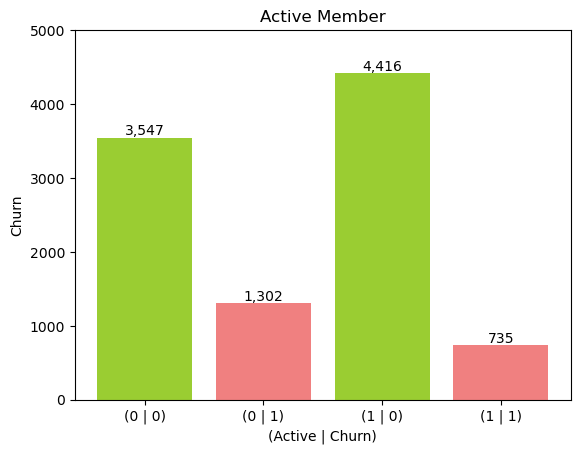

In [133]:
active_no  = active_member_df[active_member_df['active_member']==0].value_counts().unstack(fill_value=0)
active_yes = active_member_df[active_member_df['active_member']==1].value_counts().unstack(fill_value=0)

bars = ['(0 | 0)','(0 | 1)', '(1 | 0)', '(1 | 1)']

fig, ax = plt.subplots()
bar_container = ax.bar(bars, [ active_no.values[0][0], active_no.values[0][1],active_yes.values[0][0], \
               active_yes.values[0][1]], color=["yellowgreen",'lightcoral', "yellowgreen",'lightcoral'])
ax.set(ylabel='Churn', title='Active Member', xlabel=("(Active | Churn)"), ylim=(0, 5000))
ax.bar_label(bar_container, fmt='{:,.0f}')

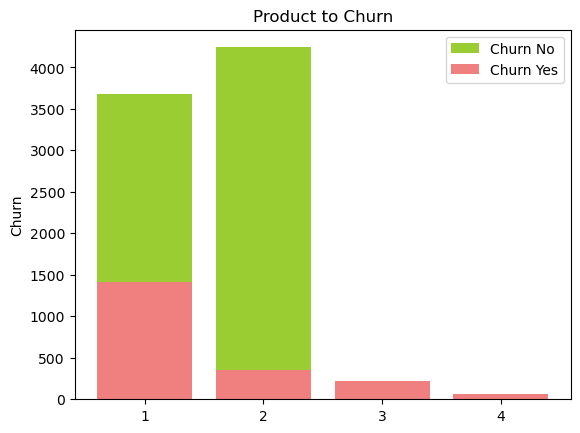

In [184]:
# Prouct number

plt.title("Product to Churn")

churn_yes = churn_df[['products_number', 'churn']].loc[churn_df['churn']==1].groupby('products_number').value_counts().unstack(fill_value=0)
churn_no = churn_df[['products_number', 'churn']].loc[churn_df['churn']==0].groupby('products_number').value_counts().unstack(fill_value=0)

plt.bar(churn_no.index,  churn_no[0],   label='Churn No',  color="yellowgreen")
plt.bar(churn_yes.index, churn_yes[1],  label='Churn Yes', color="lightcoral")
plt.xticks([1, 2, 3, 4])
plt.ylabel('Churn')
plt.legend()

In [187]:
churn_no = churn_df[['credit_card', 'churn']].loc[churn_df['churn']==0].groupby('credit_card').value_counts().unstack(fill_value=0)
churn_no

churn,0
credit_card,
0,2332
1,5631


Die Mehrheit der Leute, die aktive sind, bleiben eher.

Um später auf der Webseite wenige Features einzutragen, werden jetzt einige der derzeitigen Features herausgenommen.
- Man könnte noch mehr Analysen durchführen und Visualisierungen zeigen. Um die Funktionalität von Flask zu nutzt, reicht es erstmal.

In [188]:
# Personenbezogen: 'country', 'gender', 'age'
# Bank: 'products_number', 'active_member', 'credit_card'
dataset_df = churn_df[['country', 'gender', 'age', 'products_number', 'active_member', 'credit_card', 'churn']]
dataset_df.head()  

,country,gender,age,products_number,active_member,credit_card,churn
0,0,0,42,1,1,1,1
1,1,0,41,1,1,0,0
2,0,0,42,3,0,1,1
3,0,0,39,2,0,0,0
4,1,0,43,1,1,1,0


<h2>Training</h2>

Jetzt erstellen wir das Dataset für das Training. Vorher werden wir noch die Daten skalieren.

In [189]:
X, y = dataset_df.drop(['churn'], axis='columns'), dataset_df['churn']

In [190]:
X.shape

(10000, 6)

In [191]:
scaler   = MinMaxScaler()
# Oder StandardScaler
X[['age']] = scaler.fit_transform(X[['age']])
X

,country,gender,age,products_number,active_member,credit_card
0,0,0,0.324324,1,1,1
1,1,0,0.310811,1,1,0
2,0,0,0.324324,3,0,1
3,0,0,0.283784,2,0,0
4,1,0,0.337838,1,1,1
...,...,...,...,...,...,...
9995,0,1,0.283784,2,0,1
9996,0,1,0.229730,1,1,1
9997,0,0,0.243243,1,1,0
9998,2,1,0.324324,2,0,1


In [193]:
# Erstelle Train- und Testset.
# - stratify: Gleichmäßige Aufteilung der Klassen.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

Es gibt 3 Modelle mit verschiedenen Parametern, die wir testen werden.

In [194]:
# Dieser Vorgang kann Zeit in Anspruch nehmen.
data_dict = {
    'svc':{                 
        'model': SVC(),    
        'model_param':{  
            'C': [1, 2, 4, 5],             
            'kernel': ['rbf','linear', 'poly', 'sigmoid'],
            'degree': [2, 3, 4, 5]
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(),  
        'model_param':{   
            'n_estimators':[50, 100, 500],
            'criterion': ['gini', 'entropy', 'log_loss']
        }
    },
   'logistic_regression':{
        'model': LogisticRegression(),  
        'model_param':{   
            'solver':['lbfgs', 'newton-cholesky'] 
        }
   }
}

result = []
for model, param in data_dict.items():
    # Mit Cross-Validation 3
    grid_search = GridSearchCV( param['model'], param['model_param'], cv=3, return_train_score=False)
    grid_search.fit(X_train, y_train)

    result.append({         
        'model_name':       model,
        'best_model_score': grid_search.best_score_,
        'best_params':      grid_search.best_params_
    })
result

[{'model_name': 'svc',
  'best_model_score': 0.8483750577689416,
  'best_params': {'C': 4, 'degree': 2, 'kernel': 'rbf'}},
 {'model_name': 'random_forest',
  'best_model_score': 0.8348754792747681,
  'best_params': {'criterion': 'log_loss', 'n_estimators': 500}},
 {'model_name': 'logistic_regression',
  'best_model_score': 0.8132511193040104,
  'best_params': {'solver': 'lbfgs'}}]

In [195]:
best_modelparameters = pd.DataFrame(result, columns=list(result[0].keys()) )  
best_modelparameters

,model_name,best_model_score,best_params
0,svc,0.848375,"{'C': 4, 'degree': 2, 'kernel': 'rbf'}"
1,random_forest,0.834875,"{'criterion': 'log_loss', 'n_estimators': 500}"
2,logistic_regression,0.813251,{'solver': 'lbfgs'}


In [196]:
model = SVC(C=4, degree=2, kernel='rbf')
model

SVC(C=4, degree=2)

In [197]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.86

Text(58.222222222222214, 0.5, 'Truth')

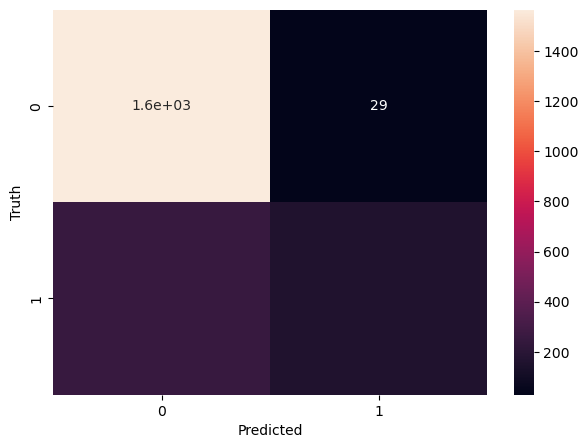

In [198]:
# Erstelle Heat-Map

cm = confusion_matrix(y_test, model.predict(X_test))

plt.figure(figsize=(7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [199]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1593
           1       0.84      0.38      0.53       407

    accuracy                           0.86      2000
   macro avg       0.85      0.68      0.72      2000
weighted avg       0.86      0.86      0.84      2000



<h2>F1-Score niedrig</h2>

Wie wir gesehen haben, ist das Dataset nicht gut balanciert. Das liegt einfach an der Natur des Datasets. Bei einem Customer Churm Dataset, das keine besonderen Auffälligkeiten hat, hat die Klasse, die den Abgang von Leute beschreibt, immer viel weniger Samples.

Es ist schon vorher klar gewesen, dass dieses Dataset diese Eigenschaft hat. Ohne das Wissen hätte man es spätestens an dem F1-Score gesehen. Oder an der verteilung der Klassen.

Es gibt verschiedene Methoden ein Gleichgewicht zu erzeigen wie: Undersampling, Oversampling, Ensemble, SMOTE, usw.

In [200]:
# Oversampling + SMOTE
high_class_df  = dataset_df[dataset_df['churn']==0]
lower_class_df = dataset_df[dataset_df['churn']==1]
lower_class_df.head()

,country,gender,age,products_number,active_member,credit_card,churn
0,0,0,42,1,1,1,1
2,0,0,42,3,0,1,1
5,1,1,44,2,0,1,1
7,2,0,29,4,0,1,1
16,2,1,58,1,0,1,1


In [201]:
class_counts = dataset_df['churn'].value_counts()
class_counts

churn
0    7963
1    2037
Name: count, dtype: int64

In [202]:
# Sample Hälfte, dann verwende SMOTE
lower_class_df = lower_class_df.sample(int(class_counts[0]/2), replace=True)
lower_class_df.shape

(3981, 7)

In [203]:
dataset = pd.concat([high_class_df, lower_class_df], axis=0)
dataset['churn'].value_counts()

churn
0    7963
1    3981
Name: count, dtype: int64

In [204]:
# SMOTE #
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(dataset.drop(['churn'], axis="columns"), dataset['churn'])
X.shape

(15926, 6)

In [205]:
# Beide Klassen haben gleich viele Samples. 
class_counts[0]*2 == X.shape[0]

True

In [206]:
scaler   = MinMaxScaler()
X[['age']] = scaler.fit_transform(X[['age']])
X.head()

,country,gender,age,products_number,active_member,credit_card
0,1,0,0.310811,1,1,0
1,0,0,0.283784,2,0,0
2,1,0,0.337838,1,1,1
3,0,1,0.432432,2,1,1
4,0,1,0.351351,2,1,0


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Danach wieder das Model trainieren und den Score ausgeben. 

In [209]:
model = SVC(C=4, degree=2, kernel='rbf')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7743251726302574

In [210]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1593
           1       0.79      0.74      0.77      1593

    accuracy                           0.77      3186
   macro avg       0.78      0.77      0.77      3186
weighted avg       0.78      0.77      0.77      3186



Der F1-Score hat sich deutlich verbessert. 

Zum Schluss speichern wir das Model. 

In [211]:
with open("1/model/churn_predict.pickle" ,'wb') as f:
    pickle.dump(model, f)  

In [212]:
# Lade Model.
with open('1/model/churn_predict.pickle', 'rb') as f:
    my_model = pickle.load(f)
my_model

SVC(C=4, degree=2)

In [213]:
print(classification_report(y_test, my_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1593
           1       0.79      0.74      0.77      1593

    accuracy                           0.77      3186
   macro avg       0.78      0.77      0.77      3186
weighted avg       0.78      0.77      0.77      3186



In [219]:
X_test[:5]

,country,gender,age,products_number,active_member,credit_card
32,1,1,0.297297,1,0,1
12198,0,1,0.500000,3,1,1
3975,1,1,0.216216,1,0,1
5733,0,1,0.310811,2,0,1
12360,0,1,0.527027,1,0,1


In [ ]:
`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))`<br>
`X_scaled = X_std * (max - min) + min`

In [254]:
dataset_df.age.min()
max_data = 92
min_data = 18


age = 63

In [255]:
X_std = (age - min_data) / (max_data - min_data)
X_scaled = X_std * (1 - 0) + 0
X_scaled

0.6081081081081081

In [256]:
X_std = (age - min_data) / (max_data - min_data)
X_std

0.6081081081081081

In [253]:
X_scaled = X_std * (1 - 0) + 0
X_scaled

0.32432432432432434